# Modelling and Evaluation Part 2

## Objectives

- Create a Sigmoid output model to predict if a cherry leaf is infected with powdery mildew, which is the primary Business Requirement
- A Softmax model has been created already with an accuracy of ___, the goal is to see if a different Sigmoid model can outperform it

## Inputs

- inputs/cherry_leaves_raw_dataset/cherry-leaves/train
- inputs/cherry_leaves_raw_dataset/cherry-leaves/validation
- inputs/cherry_leaves_raw_dataset/cherry-leaves/test
Each folder has 2 subfolders: 'healthy' and 'powdery_mildew'
- image_shape pkl [pickle] file


## Outputs

- Image distribution plot, train vs validation vs test
- Class_indices.pkl
- Machine learning model creation and training (mildew_detection_model)
- evaluation.pkl
- Plotting model performance, model_training_acc.png, model_training_losses.png
- validation_set_confusion_matrix.png, test_set_confusion_matrix.png
- Prediction on selected image files

## Install dependencies

In [1]:
pip install -r /workspace/mildew-detection/requirements.txt

You should consider upgrading via the '/home/gitpod/.pyenv/versions/3.8.12/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread



## Change working directory

Change working directory from current to parent folder.

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection/jupyter_notebooks'

In [4]:
os.chdir("/workspace/mildew-detection")
print("You set a new current directory.")

You set a new current directory.


In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection'

## Set input directories

In [6]:
data_dir = "inputs/cherry_leaves_raw_dataset/cherry-leaves"
train_dir = data_dir + "/train"
val_dir = data_dir + "/validation"
test_dir = data_dir + "/test"

## Set output directories

In [7]:
version = "v1"
file_path = f"outputs/{version}"
if "outputs" in os.listdir(current_dir) and version in os.listdir(current_dir + "/outputs"):
    print("This directory already exists, please create a new version if required.")
else:
    os.makedirs(name=file_path)

This directory already exists, please create a new version if required.


## Set label names

In [8]:
labels = os.listdir(train_dir)
print("The image labels are ", labels)

The image labels are  ['healthy', 'powdery_mildew']


Set image shape

In [9]:
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(80, 80, 3)

## Image augmentation (Sigmoid)

ImageDataGenerator will be used to augment the image pool as the data is loaded

As class_mode is different when augmenting for Sigmoid vs Softmax, this needs to be run again in this notebook

The ImageDataGenerator is imported and initialised

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

And the image pool for each set is augmented to be used in the model

### Train set

In [11]:
batch_size = 32
train_set_2 = augmented_image_data.flow_from_directory(train_dir, # Take images from 'train' folder
                                                    target_size=image_shape[:2], 
                                                    color_mode='rgb',
                                                    batch_size=batch_size, 
                                                    class_mode='binary', # sigmoid activation requires binary
                                                    shuffle=True # Shuffle the images
                                                    )
train_set_2.class_indices  

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Validation set

In [12]:
validation_set_2 = ImageDataGenerator(rescale=1./255).flow_from_directory(val_dir,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=True
                                                                        )
validation_set_2.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Test set

In [13]:
test_set_2 = ImageDataGenerator(rescale=1./255).flow_from_directory(test_dir,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=True
                                                                  )
test_set_2.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Save train set class_indices as a pkl file 

In [15]:
joblib.dump(value=train_set_2.class_indices,
            filename=f"{file_path}/class_indices_2.pkl")

['outputs/v1/class_indices_2.pkl']

## Plot augmented images for each set (showing 2 sample images from each)

### Train set

In [ ]:
for _ in range(2):
    img, label = train_set_2.next()
    print(img.shape)  
    plt.imshow(img[0])
    plt.show()

### Validation set

In [ ]:
for _ in range(2):
    img, label = validation_set_2.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

### Test set

In [ ]:
for _ in range(2):
    img, label = test_set_2.next()
    print(img.shape)
    plt.imshow(img[0])
    plt.show()

## Create sigmoid output model

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.callbacks import LearningRateScheduler

# Initial learning rate
initial_learning_rate = 1e-3

# Learning rate schedule function
def lr_schedule(epoch, learning_rate):
    if epoch < 8:
        return learning_rate  # Initial learning rate for first 8 epochs
    else:
        return learning_rate * tf.math.exp(-0.1)  # Exponentially decay the learning rate each 8 epochs

# learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

def create_model_sig(learning_rate=initial_learning_rate):
    model = Sequential()

    # input layer
    model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2,2)))

    # convolution layers
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.5))

    # output
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                optimizer=Nadam(learning_rate=learning_rate),
                metrics=['accuracy'])

    return model, lr_scheduler  # return the model and lr_scheduler callback


Show a summary of the sigmoid model

In [17]:
model, _ = create_model_sig()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 78, 78, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 37, 37, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

2024-03-27 08:48:44.690909: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Early stopping

Early stopping is included to stop the model once it starts to overfit

In [18]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)

## Fit model for training

In [19]:
model, lr_scheduler = create_model_sig()
lr_scheduler = LearningRateScheduler(lr_schedule)

model.fit(train_set_2, epochs=40, 
        steps_per_epoch=len(train_set_2.classes) // batch_size,
        validation_data=validation_set_2,
        callbacks=[early_stop, lr_scheduler],
        verbose=1
        )

2024-03-27 08:48:50.429312: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40
92/92 [==============================] - 20s 207ms/step - loss: 0.4062 - accuracy: 0.7993 - val_loss: 0.0895 - val_accuracy: 0.9595
Epoch 2/40
92/92 [==============================] - 18s 194ms/step - loss: 0.1055 - accuracy: 0.9613 - val_loss: 0.1919 - val_accuracy: 0.9143
Epoch 3/40
92/92 [==============================] - 18s 193ms/step - loss: 0.0820 - accuracy: 0.9721 - val_loss: 0.0076 - val_accuracy: 0.9976
Epoch 4/40
92/92 [==============================] - 18s 194ms/step - loss: 0.0703 - accuracy: 0.9776 - val_loss: 0.0073 - val_accuracy: 0.9976
Epoch 5/40
92/92 [==============================] - 18s 191ms/step - loss: 0.0274 - accuracy: 0.9901 - val_loss: 9.4734e-04 - val_accuracy: 1.0000
Epoch 6/40
92/92 [==============================] - 18s 192ms/step - loss: 0.0511 - accuracy: 0.9854 - val_loss: 0.0050 - val_accuracy: 0.9976
Epoch 7/40
92/92 [==============================] - 17s 189ms/step - loss: 0.0274 - accuracy: 0.9905 - val_loss: 0.0013 - val_accuracy: 1.

## Save the model

In [20]:
model.save('outputs/v1/mildew_detection_model_2.h5')

# Sigmoid model performance

## Model learning curve

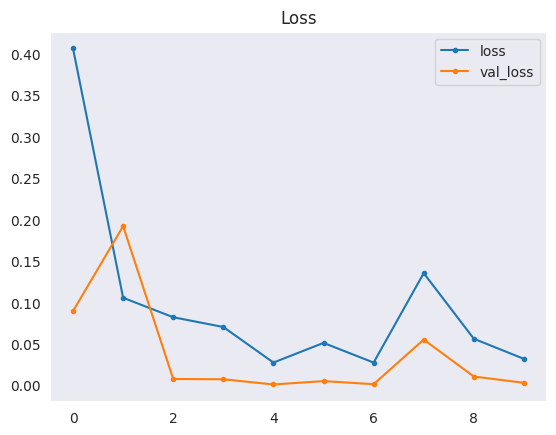

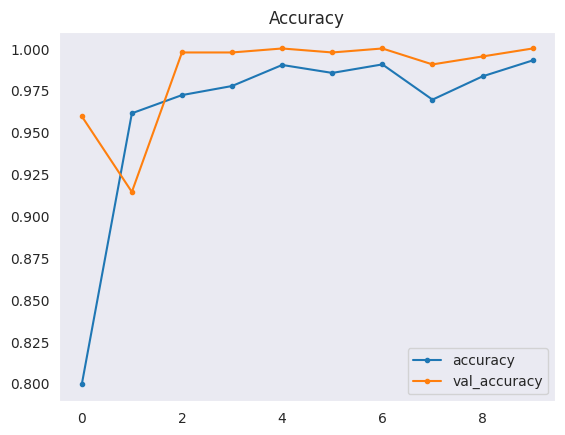

In [21]:
losses = pd.DataFrame(model.history.history)

sns.set_style("dark")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses_sigmoid.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")

losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc_sigmoid.png', bbox_inches='tight', dpi=150)
plt.show()

## Confusion matrix: Validation set

In [33]:
# from sklearn.metrics import confusion_matrix

# y_correct = test_set.labels # need to fix this
# con_mat = confusion_matrix(y_correct, y_predict)

# classes = list(validation_set_2.class_indices.keys())
# length = len(classes)

# # Swap bottom row figures (they're displaying backwards)
# con_mat_swap = con_mat.copy()
# con_mat_swap[1, 0], con_mat_swap[1, 1] = con_mat_swap[1, 1], con_mat_swap[1, 0]

# # Plot confusion matrix
# plt.figure(figsize=(7, 4))
# sns.heatmap(con_mat_swap, annot=False, vmin=0, fmt='g', cmap='flare', cbar=False)
# plt.xticks(np.arange(length) + 0.5, classes, rotation=0, fontsize=9)
# plt.yticks(np.arange(length) + 0.2, classes, rotation=90, fontsize=9)
# plt.xlabel("Predicted result")
# plt.ylabel("Actual result")
# plt.title("Validation set: Confusion Matrix (Sigmoid)\n")

# # Add labels for each section
# cm_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
# for i in range(length):
#     for j in range(length):
#         plt.text(j + 0.5, i + 0.5, f'{cm_labels[i*2+j]}\n{con_mat_swap[i, j]}', ha='center', va='center', fontsize=10, color='white')

# plt.savefig(f'{file_path}/validation_set_confusion_matrix_sigmoid.png', bbox_inches='tight', dpi=150)

# plt.show()

NameError: name 'test_set' is not defined

## Model evaluation

Load saved model

In [22]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detection_model_2.h5')

Check model performance on test set

In [23]:
evaluation = model.evaluate(test_set_2, batch_size=batch_size)
print("Model accuracy: {:.2f}%".format(evaluation[1] * 100))
print("Model Loss: {:.4f}%".format(evaluation[0]))

27/27 [==============================] - 3s 92ms/step - loss: 0.0082 - accuracy: 0.9988
Model accuracy: 99.88%
Model Loss: 0.0082%


The model performs with over ___% accuracy, easily meeting the business requirement of 97%

## Confusion Matrix

Create a confusion matrix for the test set

In [ ]:
# from sklearn.metrics import confusion_matrix

# con_mat = confusion_matrix(y_correct,y_predict)

# classes = list(test_set_2.class_indices.keys()) 
# length = len(classes)

# # Swap indices, as with validation set confusion matrix
# con_mat_swap = con_mat.copy()
# con_mat_swap[1, 0], con_mat_swap[1, 1] = con_mat_swap[1, 1], con_mat_swap[1, 0]

# # Re-plot the confusion matrix
# plt.figure(figsize=(7, 4))
# sns.heatmap(con_mat_swap, annot=False, vmin=0, fmt='g', cmap='flare', cbar=False)
# plt.xticks(np.arange(2) + 0.5, classes, rotation=0, fontsize=9)
# plt.yticks(np.arange(2) + 0.2, classes, rotation=90, fontsize=9)
# plt.xlabel("Predicted result")
# plt.ylabel("Actual result")
# plt.title("Test set: Confusion Matrix (Sigmoid)\n")

# # Add labels for each section
# cm_labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
# for i in range(length):
#     for j in range(length):
#         plt.text(j + 0.5, i + 0.5, f'{cm_labels[i*2+j]}\n{con_mat_swap[i, j]}', ha='center', va='center', fontsize=10, color='white')

# plt.savefig(f'{file_path}/test_set_confusion_matrix_sigmoid.png', bbox_inches='tight', dpi=150)

# plt.show()

Save evaluation pkl file

In [24]:
joblib.dump(value=evaluation, filename=f"outputs/v1/evaluation_sigmoid.pkl")

['outputs/v1/evaluation_sigmoid.pkl']

## Predict on new data

An image from the 'healthy' label is fed into the model to randomly check accuracy

Image shape: (80, 80), Image mode: RGB


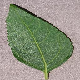

In [25]:
from tensorflow.keras.preprocessing import image
import random

label = labels[0]  # label '0' = 'healthy'
image_files = os.listdir(test_dir + '/' + label)
random_image_file = random.choice(image_files)

pil_image = image.load_img(test_dir + '/' + label + '/' + random_image_file,
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to an array for prediction

In [26]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 80, 80, 3)


The prediction is run

In [28]:
prediction_probability = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set_2.class_indices.items()}
prediction_class = target_map[prediction_probability > 0.5]

if prediction_class == target_map[0]:
    prediction_probability = 1 - prediction_probability

print(prediction_probability)
print(prediction_class)

0.9999703637622588
healthy


The steps above are repeated for a random infected image as a second check

Image shape: (80, 80), Image mode: RGB


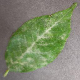

In [29]:
from tensorflow.keras.preprocessing import image
import random

label = labels[1]  # label '1' = 'powdery_mildew'
image_files = os.listdir(test_dir + '/' + label)
random_image_file = random.choice(image_files)

pil_image = image.load_img(test_dir + '/' + label + '/' + random_image_file,
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

In [30]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 80, 80, 3)


In [31]:
prediction_probability = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set_2.class_indices.items()}
prediction_class = target_map[prediction_probability > 0.5]

if prediction_class == target_map[0]:
    prediction_probability = 1 - prediction_probability

print(prediction_probability)
print(prediction_class)

0.999931
powdery_mildew


Put sensitive datafiles into .gitignore

In [ ]:
!cat .gitignore

# Conclusions

- A Sigmoid model was created and the parameters/hyperparameters tuned using different numbers of nodes, loss metrics, epochs and optimizers and emerged as extremely accurate (>99%). As seen in the confusion matrix, it correctly predicted every single image in the test set
- A larger dataset, as well as further tuning of hyperparameters may help to refine accuracy somewhat, though the model already performs far above the required 97% - there's not a lot of room to improve further
- Files were moved to .gitignore to fulfil Business Requirement 3 - not sharing official Farmy & Foods data

## Next steps

- A Streamlit Dashboard will be constructed to fulfil Business Requirement 2